In [1]:
import numpy as np

import hoomd
import gsd.hoomd
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## MD Simulation using Hoomd Blue

In [2]:
from scipy.special import lambertw

def compute_b_lambertw(l0):
    b_solution = lambertw(-2 * np.exp(-2)) / 2
    return b_solution.real

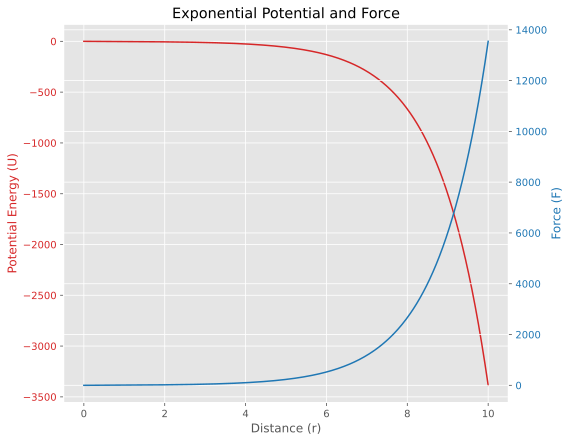

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the exponential potential
l0 = 1.0
b = compute_b_lambertw(l0) 

# Function to compute the potential energy
def exponential_potential(r, l0, b):
    return np.exp(-4 * r / l0) - np.exp(-4 * b * r / l0)

# Function to compute the force from the potential
def exponential_force(r, l0, b):
    return 4 / l0 * (np.exp(-4 * b * r / l0) - np.exp(-4 * r / l0))

# Generate a range of distances
r = np.linspace(0, 10 * l0, 500)

# Calculate the potential energy and force for each distance
U_exponential = exponential_potential(r, l0, b)
F_exponential = exponential_force(r, l0, b)

# Plot the exponential potential and force on the same graph
fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:red'
ax1.set_xlabel('Distance (r)')
ax1.set_ylabel('Potential Energy (U)', color=color)
ax1.plot(r, U_exponential, color=color, label='Exponential Potential')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Force (F)', color=color)  
ax2.plot(r, F_exponential, color=color, label='Force')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Exponential Potential and Force')
plt.show()


In [4]:
import numpy as np

def exponential_repulsion_force_energy(positions, l0):
    num_particles = len(positions)
    repulsion_forces = np.zeros((num_particles, 3), dtype=np.float32)
    repulsion_energies = np.zeros(num_particles, dtype=np.float32)

    for i in range(num_particles):
        repulsion_forces[i] -= 4 / l0 * np.sum(
            np.sign(positions[:, np.newaxis] - positions[i]) *
            np.exp(-4 * np.abs(positions[:, np.newaxis] - positions[i]) / l0) / l0,
        )
        repulsion_energies[i] = np.sum(np.exp(-4 * np.abs(positions[:, np.newaxis] - positions[i]) / l0))

    return repulsion_forces, repulsion_energies

import numpy as np

def exponential_bond_force_energy(positions, bonds, l0, b):
    num_bonds = len(bonds)
    bond_forces = np.zeros((num_bonds, 3), dtype=np.float32)
    bond_energies = np.zeros(num_bonds, dtype=np.float32)

    for i, bond in enumerate(bonds):
        particle_i, particle_j = bond
        bond_direction = positions[particle_j] - positions[particle_i]
        bond_distance = np.linalg.norm(bond_direction)

        force_magnitude = 4 * b / l0 * np.exp(-4 * b * bond_distance / l0) / l0
        bond_force = force_magnitude * bond_direction / bond_distance

        bond_forces[i] = bond_force
        bond_energies[i] = -np.sum(np.exp(-4 * b * bond_distance / l0))

    return bond_forces, bond_energies

# Example usage
positions = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0]], dtype=np.float32)
bonds = [(0, 1), (1, 2)]
l0 = 1.0
b = 0.5

repulsion_forces, repulsion_energies = exponential_repulsion_force_energy(positions, l0)
bond_forces, bond_energies = exponential_bond_force_energy(positions, bonds, l0, b)

for i in range(len(bonds)):
    print(f"Bond {bonds[i]}:")
    print(f"Bonding Forces: {bond_forces[i]}")
    print(f"Bonding Energy: {bond_energies[i]}")
    print()


Bond (0, 1):
Bonding Forces: [0.27067056 0.         0.        ]
Bonding Energy: -0.1353352814912796

Bond (1, 2):
Bonding Forces: [-0.08358815  0.08358815  0.        ]
Bonding Energy: -0.05910575017333031



In [5]:
# Define your potential parameters
l0 = 1.0
b = 0.5

# Define system parameters
dimension = 3
num_particles = 5
diffusion_coefficient = 1.0
time_step = 1e-4
num_steps = 1000

# Example bonded pairs
bonds = [(i, (i + 1) % num_particles) for i in range(num_particles - 1)]

# Example initial positions

positions = np.random.rand(num_particles, dimension)


In [6]:
repulsion_forces, repulsion_energies = exponential_repulsion_force_energy(positions, l0)
bond_forces, bond_energies = exponential_bond_force_energy(positions, bonds, l0, b)

In [7]:
bonds, bond_forces

([(0, 1), (1, 2), (2, 3), (3, 4)],
 array([[-0.07487905, -0.50979394, -0.29385546],
        [-0.12781672, -0.23616678, -0.51826024],
        [-0.09344535,  0.12220051,  0.2595822 ],
        [ 0.42522433, -0.44330093, -0.35085887]], dtype=float32))

In [47]:
class MyCustomForce(hoomd.md.force.Custom):
    def __init__(self):
        super().__init__(aniso=False)

    def update(self,positions, bonds, l0,b):
        with self.cpu_local_force_arrays as arrays:
            positions = self.snapshot.particles.position
            bonds = self.snapshot.bonds.group

            arrays.force[:] = exponential_bond_force_energy(positions, bonds, l0, b)[0] + exponential_repulsion_force_energy(positions, l0)[0]
            arrays.torque[:] = 0
            arrays.potential_energy[:] = exponential_bond_force_energy(positions, bonds, l0, b)[1] + exponential_repulsion_force_energy(positions, l0)[1]
            arrays.virial[:] = np.arange(6)[None, :]


In [49]:

frame = gsd.hoomd.Frame()

# Place a polymer in the box.
frame.particles.N = 5
frame.particles.position = [[-2, 0, 0], [-1, 0, 0], [0, 0, 0], [1, 0, 0],
                            [2, 0, 0]]
frame.particles.types = ['A']
frame.particles.typeid = [0] * 5
frame.configuration.box = [20, 20, 20, 0, 0, 0]


# Connect particles with bonds.
frame.bonds.N = 4
frame.bonds.types = ['A-A']
frame.bonds.typeid = [0] * 4
frame.bonds.group = [[0, 1], [1, 2], [2, 3], [3, 4]]

with gsd.hoomd.open(name='molecular.gsd', mode='x') as f:
    f.append(frame)

In [50]:
forces = MyCustomForce()

In [51]:
sim = hoomd.Simulation(device=hoomd.device.CPU(), seed=1)
sim.create_state_from_gsd(filename='molecular.gsd')
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
integrator = hoomd.md.Integrator(dt=0.005, methods=[langevin])
gsd_writer = hoomd.write.GSD(filename='molecular_trajectory.gsd',
                             trigger=hoomd.trigger.Periodic(1000),
                             mode='xb')

sim.run(10)

In [52]:
# Set up forces before running the simulation
integrator.forces.append(forces.update(positions=positions, bonds=bonds, l0=l0, b=b))


sim.operations.integrator = integrator
sim.operations.writers.append(gsd_writer)

# Run the simulation for the desired number of steps
sim.run(10e3)


DataAccessError: The property cpu_local_force_arrays is unavailable until the simulation runs for 0 or more steps.